# Importação das bibliotecas necessárias

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import pickle


# 1. Análise Exploratória dos Dados (EDA):

In [2]:
# Carregando dados brutos:

sales_train = pd.read_csv('predict-future-sales/sales_train.csv')
sales_test = pd.read_csv('predict-future-sales/test.csv')
itens = pd.read_csv('predict-future-sales/items.csv')
itens_categorias = pd.read_csv('predict-future-sales/item_categories.csv')
shops = pd.read_csv('predict-future-sales/shops.csv')


## 1.1. Tratamento dos Dados

### Identificação e tratamento de valores ausentes

In [5]:
sales_train.isnull().sum()

date              0
date_block_num    0
shop_id           0
item_id           0
item_price        0
item_cnt_day      0
dtype: int64

### Identificação e tratamento de dados inconsistentes

In [6]:
# Verificar se existem dados além dos valores de id fornecidos em 'shops.csv'

sales_train[(59 < sales_train['shop_id']) | (sales_train['shop_id'] < 0)].empty 


True

In [7]:
# Verificar se existem dados além dos valores de id fornecidos em 'items.csv'

sales_train[(22169 < sales_train['item_id']) | (sales_train['item_id'] < 0)].empty 

True

In [8]:
# Verificar se existem dados negativos nos preços dos produtos

sales_train[sales_train['item_price'] < 0]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
484683,15.05.2013,4,32,2973,-1.0,1.0


In [3]:
# Imputação - adicionando o valor médio:

mean_price = sales_train[(sales_train['date_block_num'] == 4) & (sales_train['shop_id'] == 32) & (sales_train['item_id'] == 2973) & (sales_train['item_price'] != -1.0)]['item_price'].mean()
sales_train['item_price'] = sales_train['item_price'].replace(-1, mean_price)

In [4]:
# Imputação: corrigindo erros de digitação (valores negativos nas quantidades de itens comprados)
# Multiplicando as quantidades de itens negativos por -1

sales_train['item_cnt_day'] = sales_train['item_cnt_day'].apply(lambda x: x * (-1.0) if x < 0 else x)


## 1.2. Visualizações e Insights

Text(-21.680555555555557, 0.5, 'Preço')

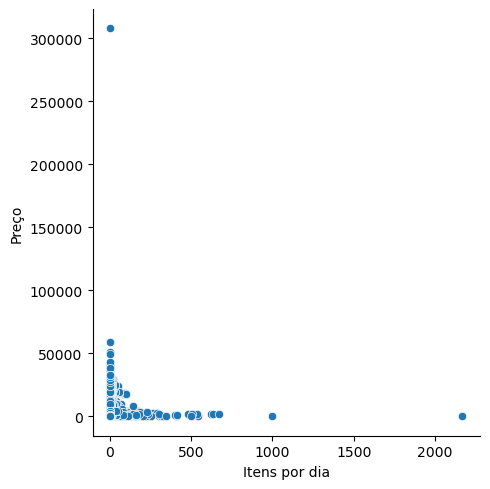

In [16]:
# Gráfico de dispersão vara visualizar a correlação entre os preços e as quantidades dos produtos

sns.relplot(x='item_cnt_day', y='item_price', data=sales_train)
plt.xlabel('Itens por dia')
plt.ylabel('Preço')


Text(-12.805555555555555, 0.5, 'Preço')

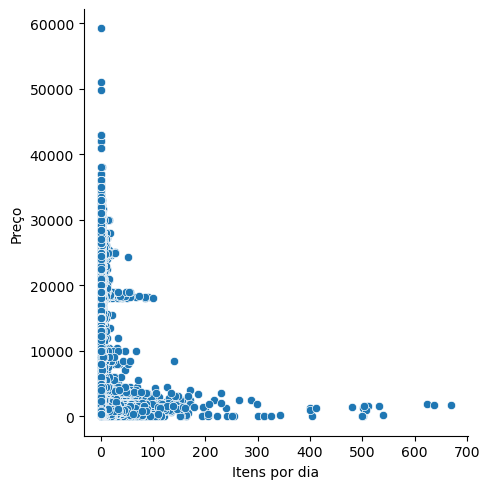

In [15]:
# Visualizando sem outliers

# sns.set_palette('colorblind')
sns.relplot(x='item_cnt_day', y='item_price', data=sales_train[(sales_train['item_price'] < 60000 ) & (sales_train['item_cnt_day'] < 1000)])
plt.xlabel('Itens por dia')
plt.ylabel('Preço')

- A quantidade de produtos vendidos aumentam à medida que os preços dos itens diminui. 

Text(0, 0.5, 'Itens por dia')

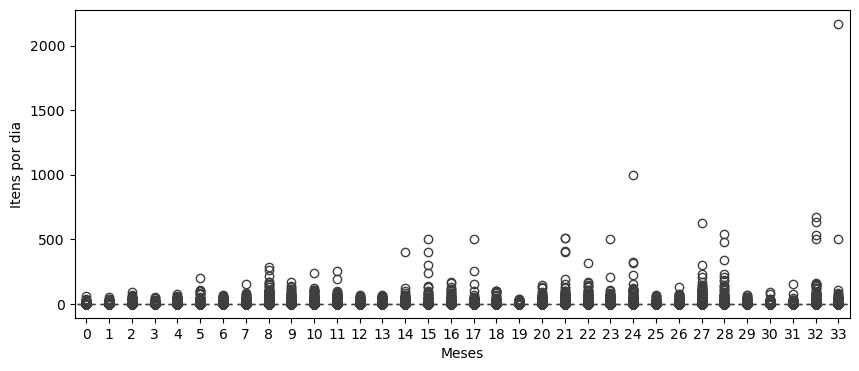

In [19]:
# Visualizando a quantidade de produtos vendidos ao longo dos meses

plt.figure(figsize=(10,4))
sns.boxplot(data=sales_train, x='date_block_num', y='item_cnt_day')
plt.xlabel('Meses')
plt.ylabel('Itens por dia')

In [17]:
# Calculando percentis de 95° a 100° da quantidade de itens vendidos

percentiles = range(95, 101)
item_counts = sales_train['item_cnt_day'].values
for p in percentiles:
    value = np.percentile(item_counts, p)
    print(f"Valor do {p}° percentil para a quantidade de itens: {value}")

Valor do 95° percentil para a quantidade de itens: 2.0
Valor do 96° percentil para a quantidade de itens: 2.0
Valor do 97° percentil para a quantidade de itens: 3.0
Valor do 98° percentil para a quantidade de itens: 3.0
Valor do 99° percentil para a quantidade de itens: 5.0
Valor do 100° percentil para a quantidade de itens: 2169.0


- Apenas 1% dos itens foram vendidos em mais de 6 unidades em uma compra
- Em particular, só existe uma venda com mais de 2000 unidades de um item

Text(0, 0.5, 'Preço')

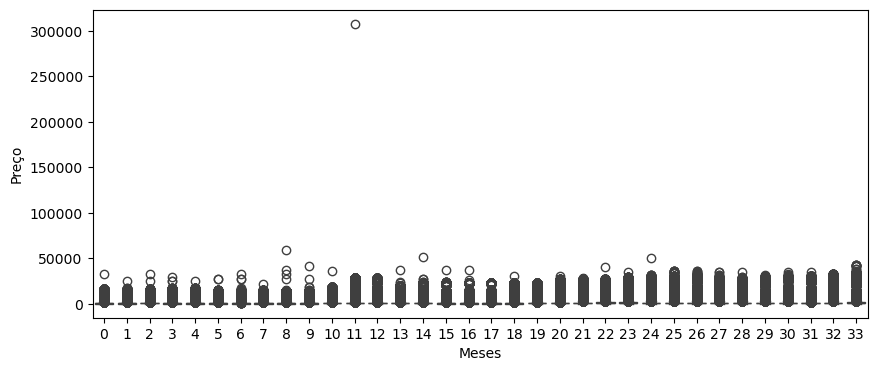

In [18]:
# Visualizando o preço dos itens vendidos ao longo dos meses

plt.figure(figsize=(10,4))
sns.boxplot(data=sales_train, x='date_block_num', y='item_price')
plt.xlabel('Meses')
plt.ylabel('Preço')

In [34]:
# Calculando percentis de 95° a 100° dos preços dos itens

percentiles = range(95, 101)
item_counts = sales_train['item_price'].values
for p in percentiles:
    value = np.percentile(item_counts, p)
    print(f"Valor do {p}° percentil para o preço: {value}")

Valor do 95° percentil para o preço: 2690.0
Valor do 96° percentil para o preço: 2999.0
Valor do 97° percentil para o preço: 3190.0
Valor do 98° percentil para o preço: 3590.0
Valor do 99° percentil para o preço: 5999.0
Valor do 100° percentil para o preço: 307980.0


- Apenas 1% dos itens foram vendidos com preço maior a 6000.0
- Outliers: existe uma venda com mais de 300000.0 de preço

Text(0, 0.5, 'Itens por dia')

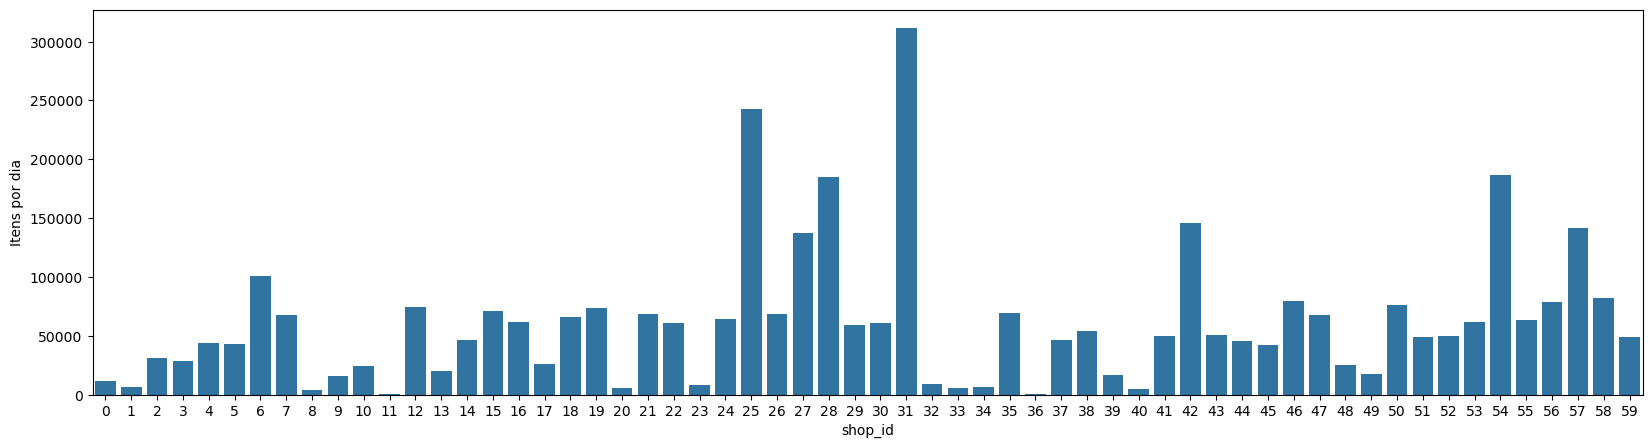

In [23]:
# Visualização de dados agrupados
# Agrupando por shops (lojas)
# Gráfico de barras entre as quantidades vendidas e lojas

plt.rcParams["figure.figsize"] = [20, 5]
group_shops = sales_train.groupby(['shop_id'])['item_cnt_day'].sum().reset_index()
sns.barplot(x='shop_id', y='item_cnt_day', data=group_shops)
plt.xlabel('shop_id')
plt.ylabel('Itens por dia')

Text(-21.680555555555557, 0.5, 'Itens por dia')

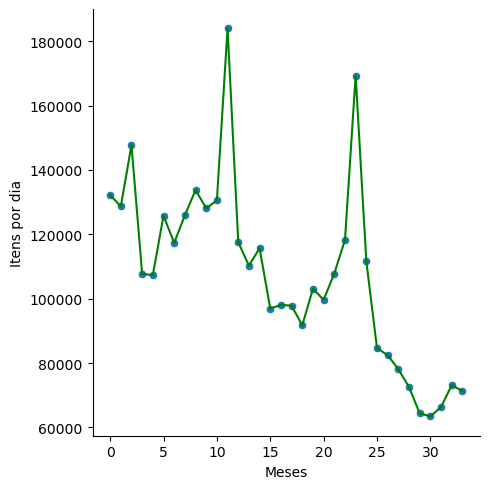

In [30]:
# Visualização de dados agrupados
# Agrupando por meses
# Gráfico de dispersão entre os meses e quantidade de produtos vendidos
# Verificando se há alguma correlação e sazonalidade entre as duas variáveis. 

group_shops = sales_train.groupby(['date_block_num'])['item_cnt_day'].sum().reset_index()
sns.relplot(x='date_block_num', y='item_cnt_day', data=group_shops)
sns.lineplot(data=group_shops, x='date_block_num', y='item_cnt_day', color='green', estimator=None)
plt.xlabel('Meses')
plt.ylabel('Itens por dia')

- Há uma correlação negativa e sazonal entre as quantidades de itens vendidos e o tempo (meses)

## 1.3. Detecção e Tratamento de Outliers

In [5]:
# Tratamento de outliers
# Insights extraidos anteriormente: 
# - Apenas 1% dos itens foram vendidos com preço maior a 6000.0
# - Apenas 1% dos itens foram vendidos em mais de 5 unidades em uma compra
# Removendo outliers: preço maior que 6000 e quantidade de itens maior que 1000 

sales_train = sales_train[(sales_train['item_price'] < 60000 ) & (sales_train['item_cnt_day'] < 1000)]

## 1.4. Seleção de características (Feature Selection and Feature Engineering)

### Adicionando features do presente de cada mês

In [6]:
# Juntando as tabelas 'itens.csv' e 'sales_train.csv'
# Objetivo: incluir a categoria dos itens ('item_category_id') como feature

df_train = sales_train.join(itens, on='item_id', rsuffix='_').drop(['item_id_','item_name'], axis=1)

In [7]:
# Adicionando features relevantes
# Criando uma cópia do DataFrame df_train
# O dataframe 'df_train_mensal' será o novo banco de dados utilizado após agrupar por mês

df_train_mensal = df_train.loc[:, ['date', 'date_block_num', 'shop_id', 'item_category_id', 'item_id', 'item_price', 'item_cnt_day']].copy()

# Adicionando uma nova coluna 'sales_proceeds' sendo como o produto do preço do item pela quantidade vendida
df_train_mensal['sales_proceeds'] = df_train_mensal.eval('item_price * item_cnt_day')

# Agrupando dados para adcionar mais features 
# São adicionados :
# - A soma mensal das quantidades por loja e por item
# - A média mensal das quantidades por loja e por item
# - A média mensal do preço dos itens
df_train_mensal = df_train_mensal.sort_values('date').groupby(['date_block_num', 'shop_id', 'item_category_id', 'item_id'], as_index=False)
df_train_mensal = df_train_mensal.agg({ 'item_cnt_day':['sum', 'mean'],'item_price':['mean'], 'sales_proceeds':['sum']})

# Definimos novos nomes para as colunas criadas
df_train_mensal.columns = ['date_block_num', 
                           'shop_id', 
                           'item_category_id', 
                           'item_id', 
                           'item_cnt_month_sum', 
                           'item_cnt_month_mean', 
                           'item_price_month_mean', 
                           'sales_proceeds_month_sum']

df_train_mensal

,date_block_num,shop_id,item_category_id,item_id,item_cnt_month_sum,item_cnt_month_mean,item_price_month_mean,sales_proceeds_month_sum
0,0,0,2,5572,10.0,1.666667,1322.00,13220.0
1,0,0,2,5573,1.0,1.000000,560.00,560.0
2,0,0,2,5575,4.0,1.333333,806.00,3224.0
3,0,0,2,5576,5.0,1.000000,2231.00,11155.0
4,0,0,2,5609,1.0,1.000000,2381.00,2381.0
...,...,...,...,...,...,...,...,...
1609117,33,59,75,5383,1.0,1.000000,4390.00,4390.0
1609118,33,59,79,17717,13.0,1.300000,802.55,11335.0
1609119,33,59,83,22087,6.0,2.000000,119.00,714.0
1609120,33,59,83,22088,2.0,1.000000,119.00,238.0


In [8]:
# Criando um dataset considerando todas as combinações possíveis entre mês, loja e item

# Criando uma lista com todos as combinações de ['shop_id','item_id']
shop_ids = sales_test['shop_id'].unique()
item_ids = sales_test['item_id'].unique()
list_combinations= [(i, shop, item) for i in range(34) for shop in shop_ids for item in item_ids]

# Definimos um novo banco de dados para todas as combinações
df_combinations = pd.DataFrame(list_combinations, columns=['date_block_num', 'shop_id', 'item_id'])

# Adicionando o mês 34 para o teste no futuro
sales_test['date_block_num'] = 34

# Vonvertimos as colunas ['date_block_num', 'shop_id', 'item_id'] em dados do tipo inteiro mais eficientes na memória
sales_test['date_block_num'] = sales_test['date_block_num'].astype(np.int8)
sales_test['shop_id'] = sales_test['shop_id'].astype(np.int8)
sales_test['item_id'] = sales_test['item_id'].astype(np.int16)

# Concatenamos os dados de 'sales_test' com 'df_combinations' para ter um dataframe compato
df_combinations = pd.concat([df_combinations, sales_test.drop(columns=['ID'])], ignore_index=True)
df_combinations.fillna(0, inplace=True)

In [9]:
# Devemos misturar o conjunto 'df_combinations' com o conjunto de treino completo 'df_train_mensal' e preencher registros faltantes com 0
df_train_mensal = pd.merge(df_combinations, df_train_mensal, on=['date_block_num','shop_id','item_id'], how='left')
df_train_mensal.fillna(0, inplace=True)

# Atualizando as colunas para adicionar o item_category_id novamente para o bloco de teste 34
df_train_mensal = df_train_mensal.drop(['item_category_id'], axis=1).join(itens, on='item_id', rsuffix='_').drop(['item_id_','item_name'], axis=1)


In [10]:
# Neste bloco adicionamos novos features calculados a partir das colunas dos dados treinamento 'df_train_mensal'
# Essas features representas dados presentes do mês 'date_block_num'

# Reorganizamos as colmnas 
df_train_mensal = df_train_mensal[['date_block_num', 
                                   'shop_id', 
                                   'item_category_id', 
                                   'item_id', 
                                   'sales_proceeds_month_sum', 
                                   'item_cnt_month_sum', 
                                   'item_cnt_month_mean',
                                   'item_price_month_mean']]

# Limitamos valores na coluna 'item_cnt_month_sum'
df_train_mensal['item_cnt_month_sum'] = df_train_mensal['item_cnt_month_sum'].fillna(0)

# Extraindo features baseadas em tempo (mês).
# Consideramos os meses de 1 a 12
df_train_mensal['month'] = (df_train_mensal['date_block_num'] + 1) % 12
df_train_mensal['month'] = df_train_mensal['month'].replace(0, 12)

# Adicionando a feature 'date_block_shop_mean'
# 'date_block_shop_mean' é a média de 'item_cnt_month_sum' agrupado por 'date_block_num' e 'shop_id'
date_block_shop_mean = df_train_mensal.groupby(['date_block_num', 'shop_id'])['item_cnt_month_sum'].mean().reset_index()
date_block_shop_mean.rename(columns={'item_cnt_month_sum': 'date_block_shop_mean'}, inplace=True)
df_train_mensal = pd.merge(df_train_mensal, date_block_shop_mean, on=['date_block_num', 'shop_id'], how='left')

# Adicionando a feature 'date_block_item_mean'
# 'date_block_item_mean' é a média de 'item_cnt_month_sum' agrupado por 'date_block_num' e 'item_id'
date_block_item_mean = df_train_mensal.groupby(['date_block_num', 'item_id'])['item_cnt_month_sum'].mean().reset_index()
date_block_item_mean.rename(columns={'item_cnt_month_sum': 'date_block_item_mean'}, inplace=True)
df_train_mensal = pd.merge(df_train_mensal, date_block_item_mean, on=['date_block_num', 'item_id'], how='left')

# Adicionando a feature 'date_block_category_mean'
# 'date_block_category_mean' é a média de item_cnt_month_sum agrupado por date_block_num e item_category_id
date_block_category_mean = df_train_mensal.groupby(['date_block_num', 'item_category_id'])['item_cnt_month_sum'].mean().reset_index()
date_block_category_mean.rename(columns={'item_cnt_month_sum': 'date_block_category_mean'}, inplace=True)
df_train_mensal = pd.merge(df_train_mensal, date_block_category_mean, on=['date_block_num', 'item_category_id'], how='left')

# Preenchendo valores ausentes com 0
df_train_mensal.fillna(0, inplace=True)

### Adicionando Features do Passado (Lag Features)

In [11]:
# Neste bloco definimos uma função que calcular os 'lag features' do pasado de cada mes do dataset
# Justificação: 
# - Lag features ajudam o modelo a capturar padrões e tendências ao longo do tempo, melhorando a precisão das previsões.
# - Importante realizar essa abordagem para implementar um modelo de regressão
# Consideramos o Dataset 'df_train_mensal' como uma série temporal de periodo mensal.
# Consideramos o passado de 3 meses anteriores para cada 'date_block_num' dos dados


def create_lag_features(df, lags, cols):
    """
    Função que calcula os valores de lag features passados.
    """
    for col in cols:
        for lag in range(1, lags + 1):
            lag_col_name = f"{col}_lag_{lag}"
            df[lag_col_name] = df.groupby(['shop_id', 'item_id'])[col].shift(lag)
    return df


# Adicionamos os lag features de 3 períodos e preenchemos registros faltantes com 0
df_train_mensal = create_lag_features(df_train_mensal, 3, ['item_cnt_month_sum',
                                                           'sales_proceeds_month_sum',
                                                           'item_cnt_month_mean',
                                                           'item_price_month_mean', 
                                                           'date_block_shop_mean',
                                                           'date_block_item_mean',
                                                           'date_block_category_mean']) 
df_train_mensal = df_train_mensal.fillna(0)


# Adicionando métricas estatísticas das novas 'lag features' no dataset
# Lista de colunas de lag features
lag_cols = ['item_cnt_month_sum_lag_1', 'item_cnt_month_sum_lag_2', 'item_cnt_month_sum_lag_3']

# Adicionando a média
df_train_mensal['lag_mean'] = df_train_mensal[lag_cols].mean(skipna=True, axis=1)

# Adicionando o desvio padrão
df_train_mensal['lag_std'] = df_train_mensal[lag_cols].std(skipna=True, axis=1) 

# Adicionando o valor mínimo
df_train_mensal['lag_min'] = df_train_mensal[lag_cols].min(skipna=True, axis=1) 

# Adicionando o valor máximo
df_train_mensal['lag_max'] = df_train_mensal[lag_cols].max(skipna=True, axis=1) 

### Preprocessamento e preparação dos dados

In [12]:
# Definindo as variáveis preditoras (X) e os targets (y)
# Devemos treinar apenas dados do pasado prevenientes do 'lag features'

# Excluindo os features relacionados a dados mensais do presente no tempo de cada registro
X = df_train_mensal.drop(['item_cnt_month_sum',
                          'item_price_month_mean',
                          'sales_proceeds_month_sum',
                          'item_cnt_month_mean', 
                          'date_block_shop_mean',
                          'date_block_item_mean',
                          'date_block_category_mean'], axis=1)
y = df_train_mensal['item_cnt_month_sum']

# Aplicando one label encoding para os features categoricos 

colunas_encode = ['item_category_id', 'month']
label_encoders = {}
for column in colunas_encode:
    label_encoders[column] = LabelEncoder()
    X[column + '_encoded'] = label_encoders[column].fit_transform(X[column])

X = X.drop(['item_category_id', 'month'], axis=1)

# Filtrando os dados para o conjunto de treinamento
X_train = X[(X['date_block_num'] < 33) & (X['date_block_num'] > 2)]
y_train = y[(X['date_block_num'] < 33) & (X['date_block_num'] > 2)]

# Filtrando os dados para o conjunto de validação
X_val = X[X['date_block_num'] == 33]
y_val = y[X['date_block_num'] == 33]

# Filtrando os dados para o conjunto de teste
X_test = X[X['date_block_num'] == 34]

## 1.5. Modelo de Regressão

In [44]:
# Visto que os dados são estruturados e com alguns features sendo categoricas, 
# escolhemos modelos baseados em árvore decissão.
# Utilizamos modelo XGboost dada a sua alta performance, tanto no tempo de execução quanto a sua corretude.
 

# Criando o modelo XGBoost
model = xgb.XGBRegressor(objective='reg:squarederror', 
                         n_estimators=100, 
                         learning_rate=0.1, 
                         max_depth=3, 
                         random_state=42)

# Treinamento do modelo
model.fit(X_train, y_train)

# Fazendo previsões no conjunto de validação
y_pred = model.predict(X_val)

# Avaliação com Métricas MSE e RMSE
mse = mean_squared_error(y_val, y_pred)
print(f'Mean Squared Error: {mse}')
print(f'Root Mean Squared Error: {np.sqrt(mse)}')

Mean Squared Error: 2.9458696996004208
Root Mean Squared Error: 1.716353605642037


## 1.6. Avaliação de desempenho e validação cruzada

### Validação cruzada

In [34]:
# Usameroms uma validação em splits consecutivos para series temporais.
# Usaremos os últimos 10 meses como os folds


# XGBoost
model = xgb.XGBRegressor(objective='reg:squarederror', 
                         n_estimators=100, 
                         learning_rate=0.1, 
                         max_depth=3, 
                         random_state=42)
resultados = []

folds = 10
for i in range(folds + 1):    
    partial = folds - i
    # Filtrando os dados para o conjunto de treinamento
    X_train = X[(X['date_block_num'] < 33 - partial) & (X['date_block_num'] > 33 - partial - 10)]
    y_train = y[(X['date_block_num'] < 33 - partial) & (X['date_block_num'] > 33 - partial - 10)]

    # Filtrando os dados para o conjunto de validação
    X_val = X[X['date_block_num'] == 33 - partial]
    y_val = y[X['date_block_num'] == 33 - partial]
    
    # Treinamento do modelo
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)

    # Avaliação com Métricas MSE, RMSE, R²
    mse = mean_squared_error(y_val, y_pred)
    print(f'Mês atual: {33 - partial}')
    print(f'Root Mean Squared Error: {np.sqrt(mse)}')
    resultados.append(np.sqrt(mse))


Mês atual: 23
Root Mean Squared Error: 3.131846460789476
Mês atual: 24
Root Mean Squared Error: 3.634299211397666
Mês atual: 25
Root Mean Squared Error: 2.5240010656022442
Mês atual: 26
Root Mean Squared Error: 1.5526278550368195
Mês atual: 27
Root Mean Squared Error: 3.874934813268678
Mês atual: 28
Root Mean Squared Error: 3.067042944311394
Mês atual: 29
Root Mean Squared Error: 1.789819387835046
Mês atual: 30
Root Mean Squared Error: 1.2850483179765513
Mês atual: 31
Root Mean Squared Error: 1.2662323180926371
Mês atual: 32
Root Mean Squared Error: 1.4675597810483982
Mês atual: 33
Root Mean Squared Error: 1.7371042848652334


### Avaliação de Desempenho

Text(0, 0.5, 'RMSE')

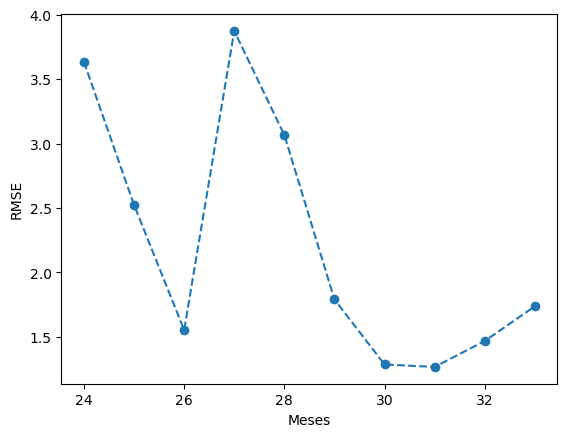

In [36]:
# Visualizando o desempenho do modelo no tempo

meses = range(24, 34)
plt.plot(meses, resultados[1:], linestyle='dashed', marker='o')
plt.xlabel('Meses')
plt.ylabel('RMSE')

### Interpretação de Resultados

- Existe uma sazonalidade nos reultados do modelo entre os meses 24 (janeiro de 2015) e 30 (julio de 2015)
- Notamos que não há uma tendência na redução do erro consistente ao longo do tempo


In [ ]:
# Gerando o resultado final do conjunto de teste em um arquivo csv

# Criando o modelo XGBoost
model = xgb.XGBRegressor(objective='reg:squarederror', 
                         n_estimators=100, 
                         learning_rate=0.1, 
                         max_depth=3, 
                         random_state=42)

# Treinamento do modelo
model.fit(X_train, y_train)

# Fazendo previsões no conjunto de validação
y_pred = model.predict(X_test)
y_pred = np.round_(y_pred)

# Crie um DataFrame com o array como uma coluna
# Aqui, 'nome_da_coluna' é o nome que você deseja dar à coluna no DataFrame
resultados_predict = pd.DataFrame({'item_cnt_month': y_pred})

# Exporte o DataFrame para um arquivo CSV
resultados_predict.to_csv('predict-future-sales/results.csv', index=True)

### Persistência do Modelo

In [41]:
# Criando o modelo definitivo para ser utilizado em ambiente de produção
# O modelo será utilizado para realizar inferencias por meio de uma requisição em um ambiente de produção
# É necessário ter o banco de dados para realizar o mapeamentos dos features que serão utilizados no modelo

# Filtrando os dados para o conjunto de treinamento
X_train = X[(X['date_block_num'] < 34) & (X['date_block_num'] > 2)]
y_train = y[(X['date_block_num'] < 34) & (X['date_block_num'] > 2)]

# Filtrando os dados para o conjunto de teste
X_test = X[X['date_block_num'] == 34]

# XGBoost
model = xgb.XGBRegressor(objective='reg:squarederror', 
                         n_estimators=100, 
                         learning_rate=0.1, 
                         max_depth=3, 
                         random_state=42)
model.fit(X_train, y_train)

# Persistência do modelo para utilização em um endpoint de predição
with open('model.pkl', 'wb') as file:
    pickle.dump(model, file)

# Salvando o Dataframe dos features de teste
with open('test.pkl', 'wb') as file:
    pickle.dump(X_test, file)
